# July 2023 Deep Learning Project
## Moving MNIST: a sequence prediction task

In this notebook, I'll be experimenting with Convolutional LSTMs to solve the Moving MNIST problem in the July 2023 Deep Learning exam. All the code will be commented where necessary ("import numpy" probably doesn't need much of an explanation) and Markdown cells will add background to the research done for the composition of this notebook.


In [2]:
# All necessary imports
import tensorflow as tf
from tensorflow import keras
from keras import layers
import tensorflow_datasets as tfds

import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
# Downloading the dataset...
ds = tfds.as_numpy(tfds.load(
    'moving_mnist',
    split='test',
    batch_size=-1
))
sequences = ds['image_sequence']

In [4]:
# ...and fixing its dimensions while also normalizing, as was done in the example notebook.
sequences = np.squeeze(np.swapaxes(sequences, 1, 4),axis=1)/255.
print(sequences.shape)
print(np.min(sequences),np.max(sequences))

(10000, 64, 64, 20)
0.0 1.0


The dataset has 10k sequences of 64x64 videos composed of 20 frames, which are already normalized into the 0-1 range, optimal for ML. Let's split the dataset into a test set composed of 80% of the images, a validation set composed of 10% and a test set of the remaining 10%. Then we'll split the whole dataset in groups of 3+1 frames, in order to use all images once.

(Theoretically, even more 4-frames splits could be done, taking for example the last 2 frames of a sequence and the first two of the next one, but since I'm working with a local GPU I have troubles handling the 40k sequences already)

In [5]:
# Reordering the axes for easy access during training
trainset = np.expand_dims(sequences[:8000].transpose(0,3,1,2), axis=4)
valset = np.expand_dims(sequences[8000:9000].transpose(0,3,1,2), axis=4)
testset = np.expand_dims(sequences[9000:10000].transpose(0,3,1,2), axis=4)
print(trainset.shape)

(8000, 20, 64, 64, 1)


In [6]:
# Precisely splitting the dataset so to have 40000 series of 3 images + 40000 target frames...
x_train = np.concatenate([trainset[:,:3,:,:,:], trainset[:,4:7,:,:,:], trainset[:,8:11,:,:,:], trainset[:,12:15,:,:,:], trainset[:,16:19,:,:,:]], axis=0)
y_train = np.concatenate([trainset[:,3:4,:,:,:], trainset[:,7:8,:,:,:], trainset[:,11:12,:,:,:], trainset[:,15:16,:,:,:], trainset[:,19:20,:,:,:]], axis=0)
print(x_train.shape, y_train.shape)
x_val = np.concatenate([valset[:,:3,:,:,:], valset[:,4:7,:,:,:], valset[:,8:11,:,:,:], valset[:,12:15,:,:,:], valset[:,16:19,:,:,:]], axis=0)
y_val = np.concatenate([valset[:,3:4,:,:,:], valset[:,7:8,:,:,:], valset[:,11:12,:,:,:], valset[:,15:16,:,:,:], valset[:,19:20,:,:,:]], axis=0)
x_test = np.concatenate([testset[:,:3,:,:,:], testset[:,4:7,:,:,:], testset[:,8:11,:,:,:], testset[:,12:15,:,:,:], testset[:,16:19,:,:,:]], axis=0)
y_test = np.concatenate([testset[:,3:4,:,:,:], testset[:,7:8,:,:,:], testset[:,11:12,:,:,:], testset[:,15:16,:,:,:], testset[:,19:20,:,:,:]], axis=0)


(40000, 3, 64, 64, 1) (40000, 1, 64, 64, 1)


In [7]:
# ...and shuffling it among the 3 sets, using a numpy permutation in order to preserve the x-y correlation
ind_1 = np.random.permutation(x_train.shape[0])
ind_2 = np.random.permutation(x_val.shape[0])
ind_3 = np.random.permutation(x_test.shape[0])

DATASET_SIZE = 40000 # This can be used to reduce the dataset size, useful for example during model selection

x_train = x_train[ind_1, :, :, :][0:DATASET_SIZE]
y_train = y_train[ind_1, :, :, :][0:DATASET_SIZE]
x_val = x_val[ind_2, :, :, :, :][0:int(DATASET_SIZE/8)]
y_val = y_val[ind_2, :, :, :, :][0:int(DATASET_SIZE/8)]
x_test = x_test[ind_3, :, :, :, :][0:int(DATASET_SIZE/8)]
y_test = y_test[ind_3, :, :, :, :][0:int(DATASET_SIZE/8)]

print(x_train.shape, y_train.shape)


(40000, 3, 64, 64, 1) (40000, 1, 64, 64, 1)


As reported in "Video (language) modeling: a baseline for generative models of natural videos" ([Ranzato et al., 2014](https://arxiv.org/abs/1412.6604)) simply applying MSE as the loss to a generic model will not work, because any model is able to produce relatively low reconstruction errors by merely blurring the last frame (or, in this case, by outputting a blank picture), and no learning will occurr. Below is an example of "92% accuracy".

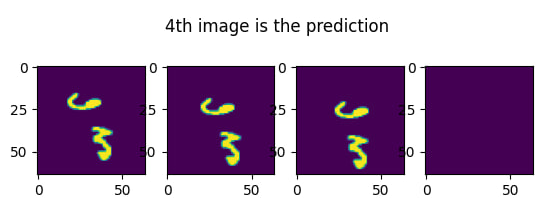

In fact, we need a dedicated model to the task: the following approach is based on the Convolutional LSTM architecture, which brings together time-series analysis and computer vision ("Convolutional LSTM Network: A Machine Learning Approach for Precipitation Nowcasting", [Xingjian Shi et al., 2015](https://arxiv.org/abs/1506.04214)).

This model is made of 3 ConvLSTMs with diminishing Kernel sizes, ending in a Conv3D Layer used to obtain a spatiotemporal output (third dimension is time) as suggested in "Learning Spatiotemporal Features with 3D Convolutional Networks", [Du Tran et al., 2014](https://arxiv.org/abs/1412.0767).

I applied a grid search for model selection (sadly with a limited training set, due to my available computational power) on the sizes of the Kernels, on the amount of filters in the ConvLSTMs and on the Learning Rate of the optimizer.

The following are the 3 best models obtained from the model selection:

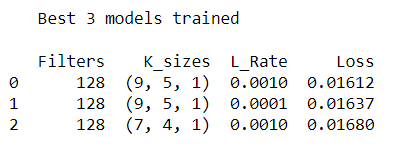

Following this table, the final model will have 3 ConvLSTMs with Kernels of size 9x9, 5x5 and 1x1 and will use 128 filters.
At this point, I did a complete training of the model with 10 epochs on the complete dataset.

In [17]:
EPOCHS = 5 # Number of training epochs, I actually did 10 total running the code twice and using checkpoints

model = keras.models.Sequential() # Model defined as explained above
model.add(layers.Input(shape=(None,64,64,1)))
model.add(layers.ConvLSTM2D(filters=128, kernel_size=(9,9), 
                            padding="same", return_sequences=True, activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.ConvLSTM2D(filters=128, kernel_size=(5, 5), 
                            padding="same", return_sequences=True, activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.ConvLSTM2D(filters=128, kernel_size=(1, 1), 
                            padding="same", return_sequences=True, activation="relu"))
model.add(layers.Conv3D(filters=1, kernel_size=(4, 4, 4), activation="sigmoid", padding="same"))

model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(learning_rate=0.001))

checkpoint_filepath = 'tmp/checkpoint_3D_3' # Path for the 2nd checkpoint
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min', 
    save_best_only=True)

model.load_weights('tmp/checkpoint_3D_2')  # <--- Used to resume checkpoint
history = model.fit(x_train, y_train, batch_size=10, epochs=EPOCHS, validation_data=(x_val, y_val),
                   callbacks=[model_checkpoint_callback])


Epoch 1/5
4000/4000 [==============================] - 4322s 1s/step - loss: 0.0094 - val_loss: 0.0099
Epoch 2/5
4000/4000 [==============================] - 4328s 1s/step - loss: 0.0091 - val_loss: 0.0100
Epoch 3/5
4000/4000 [==============================] - 4308s 1s/step - loss: 0.0089 - val_loss: 0.0099
Epoch 4/5
4000/4000 [==============================] - 4297s 1s/step - loss: 0.0087 - val_loss: 0.0099
Epoch 5/5
4000/4000 [==============================] - 4380s 1s/step - loss: 0.0085 - val_loss: 0.0099


All weights after 5 epochs, 10 epochs and at the best epoch have been saved on disk and can be made available at request.

Now, since the model still outputs a full 3-frame sequence, I visualized it and chose what to actually use as the prediction.

1/1 [==============================] - 0s 36ms/step


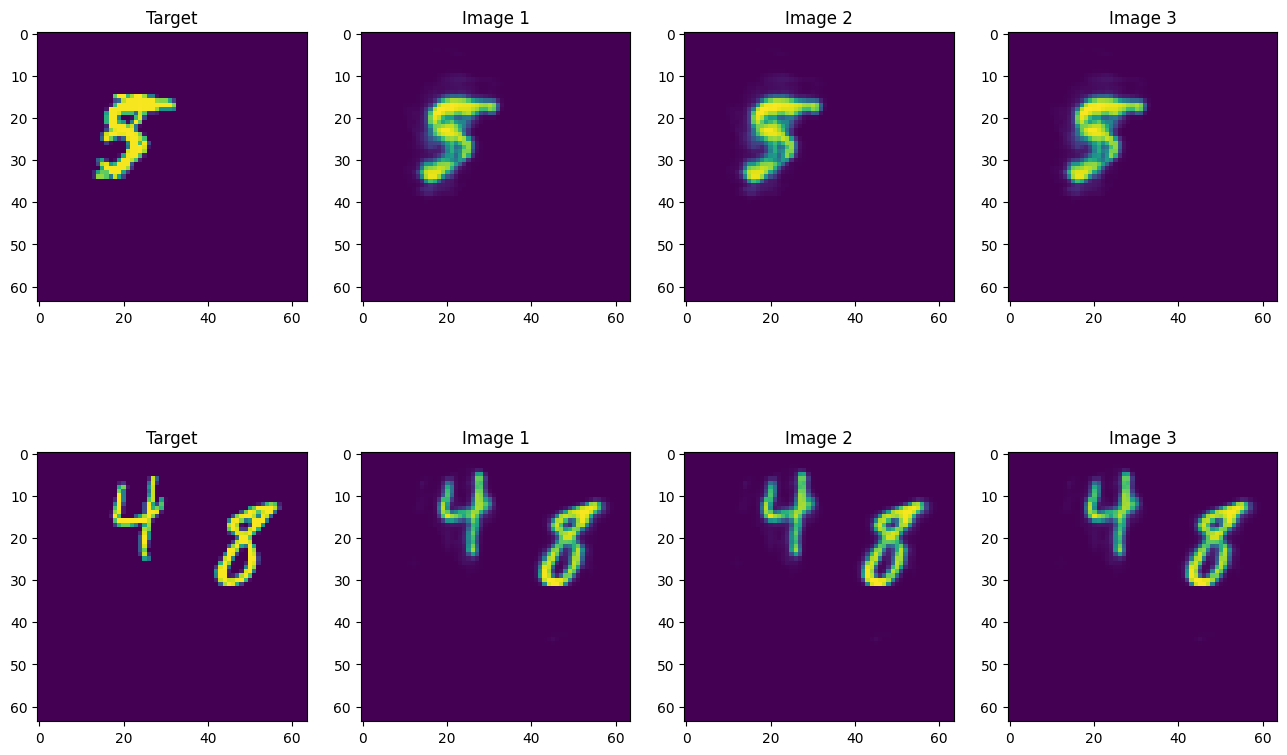

In [35]:
x = model.predict(x_val[0:10])             # Predict a random section of the test set 
mse = tf.keras.losses.MeanSquaredError()

fig, ax = plt.subplots(2, 4, figsize=(16,10))
for i in range(2):
    ax[i][0].imshow(y_val[i, 0, :, :,:])
    ax[i][0].set_title('Target')
    for j in range(3):
        ax[i][j+1].imshow(x[i, j, :, :,:])
        ax[i][j+1].set_title('Image ' + str(j+1))

Since the images are almost identical, I decided to calculate the average MSE on the Validation Set and use the lowest-scoring one as the actual target.

In [36]:
model.load_weights('tmp/checkpoint_3D_3')  # <--- Load weights of the best model in training w.r.t. val_loss
y_pred = model.predict(x_val)

157/157 [==============================] - 353s 2s/step


In [37]:
MSE_1 = mse(y_val[:, 0, :, :,:], y_pred[:, 0, :, :,:]).numpy()
MSE_2 = mse(y_val[:, 0, :, :,:], y_pred[:, 1, :, :,:]).numpy()
MSE_3 = mse(y_val[:, 0, :, :,:], y_pred[:, 2, :, :,:]).numpy()
print("Best MSE is", min(MSE_1, MSE_2, MSE_3), "of image n.", np.argmin([MSE_1, MSE_2, MSE_3]) + 1)

Best MSE is 0.009905176 of image n. 2


Lastly, I defined a function selecting our image at prediction time, and ran a definitive test to see my final MSE on the test set:

In [8]:
def custom_predict(M, X):   
    Y = M.predict(X)
    return Y[:, 1:2, :, :,:] # Very simply, use the standard prediction function and return only the second image.

In [39]:
y_test_pred = custom_predict(model, x_test)
MSE_test = mse(y_test, y_test_pred).numpy()
print("Final result is an MSE of", MSE_test) # Final score for this model!

157/157 [==============================] - 354s 2s/step
Final result is an MSE of 0.010013093


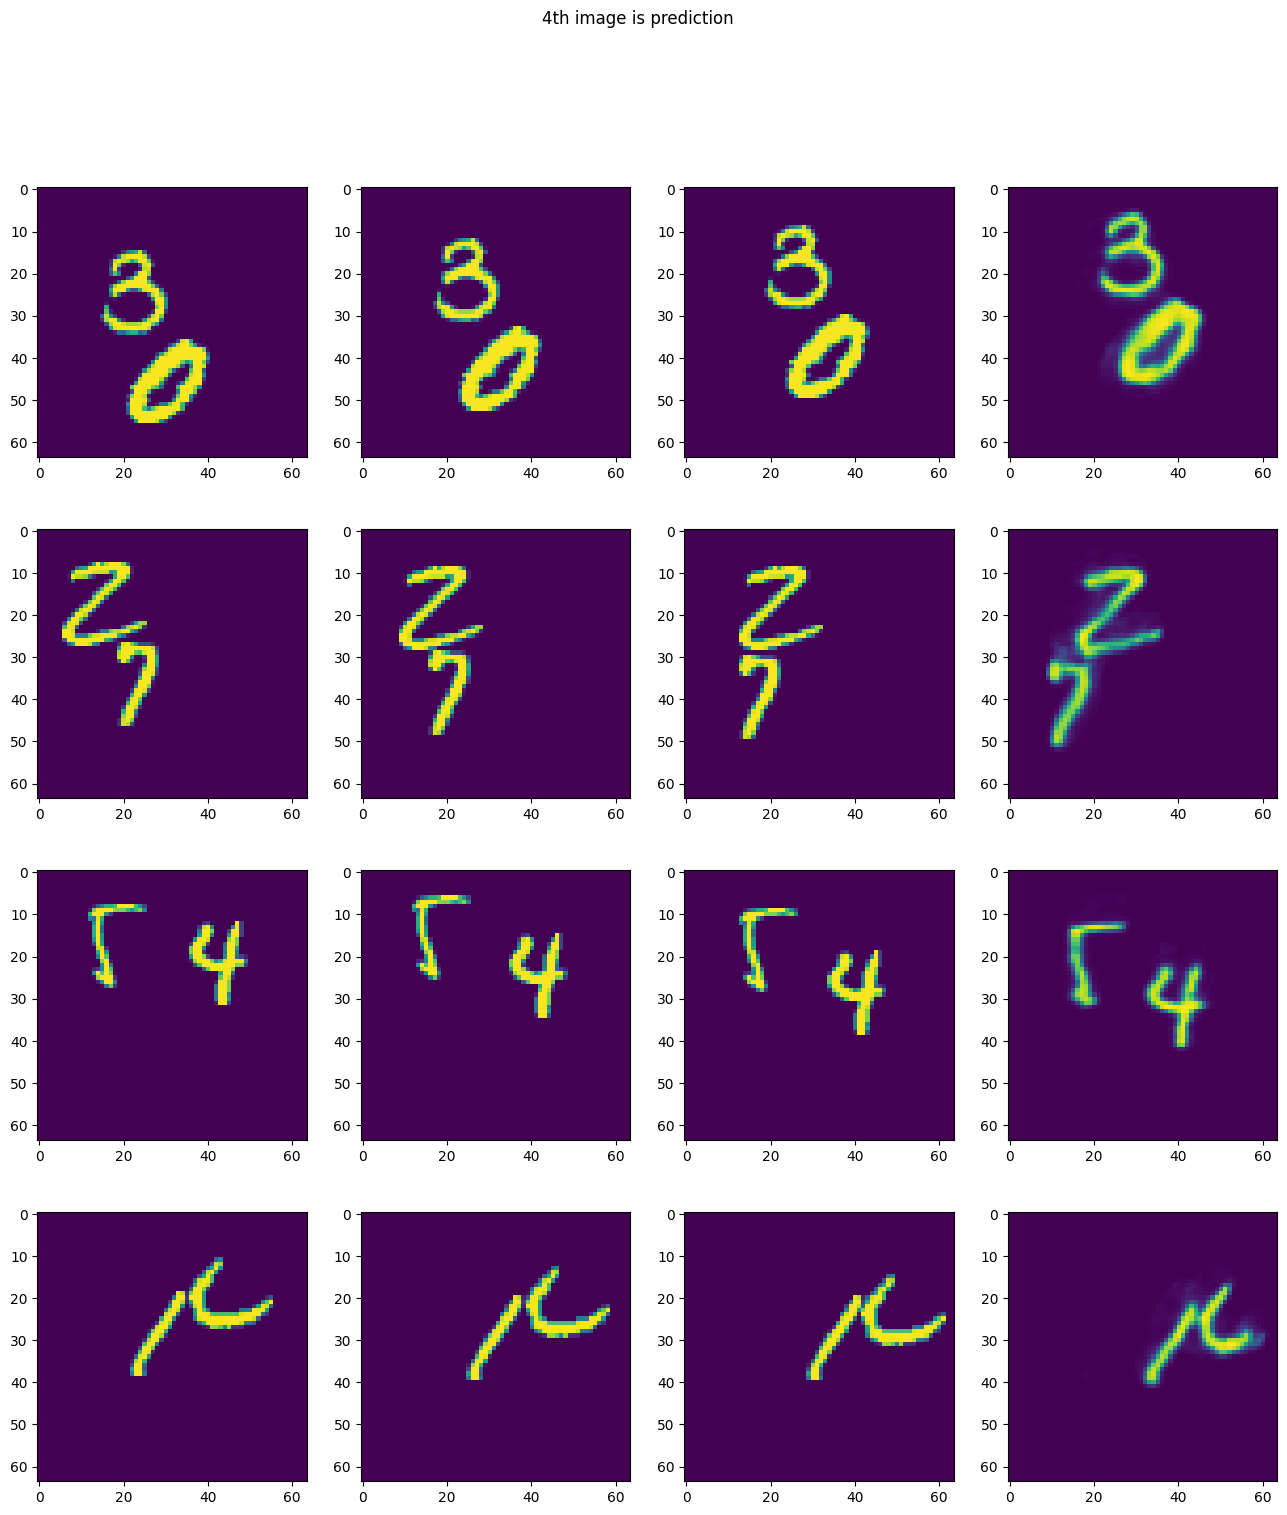

In [44]:
# A bit of visualization of the model's results
fig, ax = plt.subplots(4, 4, figsize=(16,17))
fig.suptitle('4th image is prediction')
OFFSET = 100
for i in range(4):
    ax[i][0].imshow(x_test[i+OFFSET, 0, :, :,:])
    ax[i][1].imshow(x_test[i+OFFSET, 1, :, :,:])
    ax[i][2].imshow(x_test[i+OFFSET, 2, :, :,:])
    ax[i][3].imshow(y_test_pred[i+OFFSET, 0, :, :,:])

At this point, I could've called it a day and be content with an MSE of 0.01, but I tried something else too. 

Firstly, I tried to resume the training, using this time a custom loss function: still Mean Squared Error, but only applied to the image we selected as the actual target. This way, a bit more targeted training could let us achieve a score of 0.009X. This ended up not working, and actually only caused overfitting to increase. 

Therefore, I tried to expand the training set: since I only ever used fixed sequences of frames, I re-built the training set (NOT the test set) using different sequences, shifted by 2 frames: this way, we could get more generalized training, at the expense of the dataset size (reduced from 40.000 to 32.000 since we're discarding the extremes of the sequences).

(Please note that only the training set and validation set are used in all training sections and selection procedures, while the test set is only exclusively used to calculate the final MSE, in order to keep the result as true as possible since it is data "never before seen" by the algorithm.)

In [45]:
# Precisely splitting the dataset so to have 32000 series of 3 images this time, + 32000 target frames...
x_train_2 = np.concatenate([trainset[:,2:5,:,:,:], trainset[:,6:9,:,:,:], trainset[:,10:13,:,:,:], trainset[:,14:17,:,:,:]], axis=0)
y_train_2 = np.concatenate([trainset[:,5:6,:,:,:], trainset[:,9:10,:,:,:], trainset[:,13:14,:,:,:], trainset[:,17:18,:,:,:]], axis=0)
print(x_train_2.shape, y_train_2.shape)
x_val_2 = np.concatenate([valset[:,2:5,:,:,:], valset[:,6:9,:,:,:], valset[:,10:13,:,:,:], valset[:,14:17,:,:,:]], axis=0)
y_val_2 = np.concatenate([valset[:,5:6,:,:,:], valset[:,9:10,:,:,:], valset[:,13:14,:,:,:], valset[:,17:18,:,:,:]], axis=0)


(32000, 3, 64, 64, 1) (32000, 1, 64, 64, 1)


In [46]:
# ...and shuffling it among the 3 sets, using a numpy permutation in order to preserve the x-y correlation
ind_1 = np.random.permutation(x_train_2.shape[0])
ind_2 = np.random.permutation(x_val_2.shape[0])
ind_3 = np.random.permutation(x_test_2.shape[0])

DATASET_SIZE = x_train_2.shape[0] # This can be used to reduce the dataset size, useful for example during model selection

x_train_2 = x_train_2[ind_1, :, :, :][0:DATASET_SIZE]
y_train_2 = y_train_2[ind_1, :, :, :][0:DATASET_SIZE]
x_val_2 = x_val_2[ind_2, :, :, :, :][0:int(DATASET_SIZE/8)]
y_val_2 = y_val_2[ind_2, :, :, :, :][0:int(DATASET_SIZE/8)]

print(x_train_2.shape, y_train_2.shape)

(32000, 3, 64, 64, 1) (32000, 1, 64, 64, 1)


In [52]:
EPOCHS = 5 # Number of training epochs, I actually only did 5 this time since the model was already partially trained

model_2 = keras.models.Sequential() # Model defined exactly as the previous one
model_2.add(layers.Input(shape=(None,64,64,1)))
model_2.add(layers.ConvLSTM2D(filters=128, kernel_size=(9,9), 
                            padding="same", return_sequences=True, activation="relu"))
model_2.add(layers.BatchNormalization())
model_2.add(layers.ConvLSTM2D(filters=128, kernel_size=(5, 5), 
                            padding="same", return_sequences=True, activation="relu"))
model_2.add(layers.BatchNormalization())
model_2.add(layers.ConvLSTM2D(filters=128, kernel_size=(1, 1), 
                            padding="same", return_sequences=True, activation="relu"))
model_2.add(layers.Conv3D(filters=1, kernel_size=(4, 4, 4), activation="sigmoid", padding="same"))

model_2.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(learning_rate=0.001))

checkpoint_filepath_2 = 'tmp/checkpoint_3D_custom' # Path for the second checkpoint
model_checkpoint_callback_2 = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath_2,
    save_weights_only=True,
    monitor='val_loss',
    mode='min', 
    save_best_only=True)

model_2.load_weights('tmp/checkpoint_3D_3')  # <--- Used to resume checkpoint of the previous model
history = model_2.fit(x_train_2, y_train_2, batch_size=10, epochs=EPOCHS, validation_data=(x_val_2, y_val_2),
                   callbacks=[model_checkpoint_callback_2])


Epoch 1/5
3200/3200 [==============================] - 3497s 1s/step - loss: 0.0098 - val_loss: 0.0098
Epoch 2/5
3200/3200 [==============================] - 3514s 1s/step - loss: 0.0094 - val_loss: 0.0095
Epoch 3/5
3200/3200 [==============================] - 3545s 1s/step - loss: 0.0091 - val_loss: 0.0097
Epoch 4/5
3200/3200 [==============================] - 3486s 1s/step - loss: 0.0089 - val_loss: 0.0096
Epoch 5/5
3200/3200 [==============================] - 3482s 1s/step - loss: 0.0086 - val_loss: 0.0096


In [12]:
model_2.load_weights('tmp/checkpoint_3D_custom')  # <--- Load weights of the best model in training w.r.t. val_loss
y_test_pred_2 = custom_predict(model_2, x_test)
MSE_test_2 = mse(y_test, y_test_pred_2).numpy()
print("Final result is an MSE of", MSE_test_2) # Final score for this model!

157/157 [==============================] - 226s 1s/step
Final result is an MSE of 0.009755889


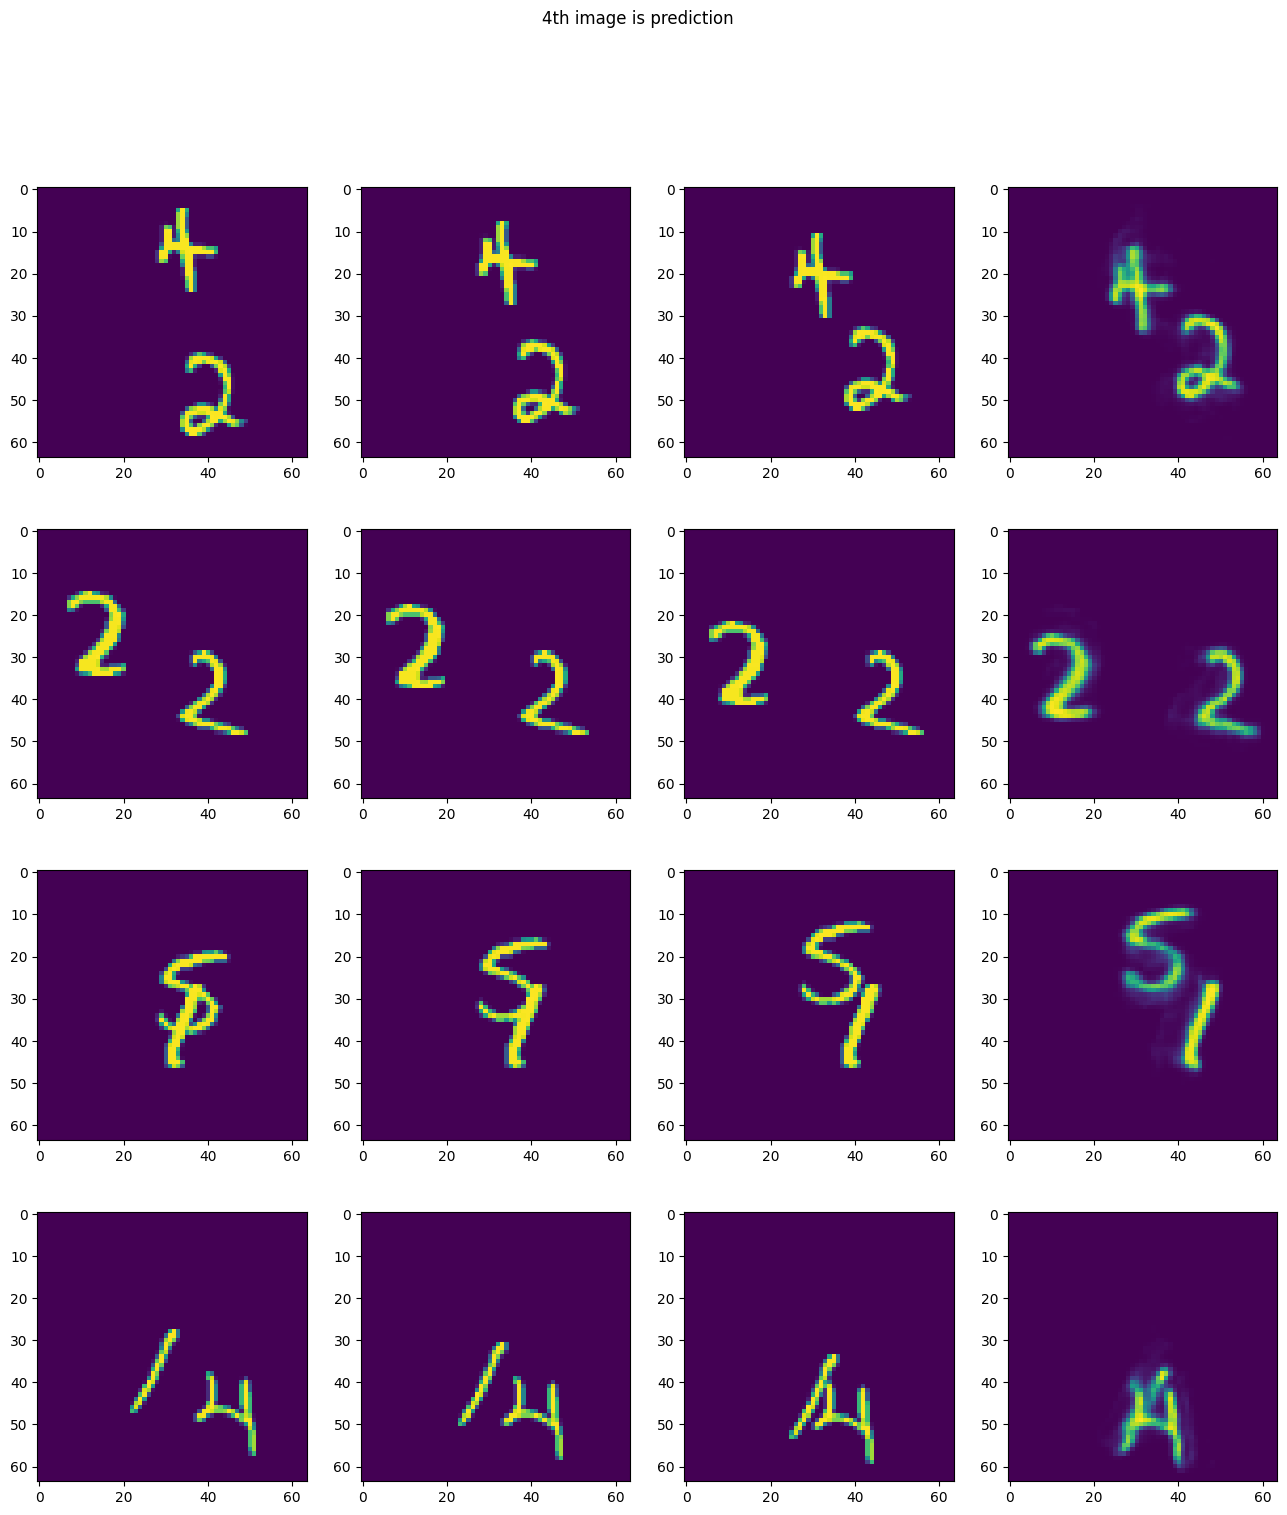

In [61]:
# A bit of visualization of the model's results
fig, ax = plt.subplots(4, 4, figsize=(16,17))
fig.suptitle('4th image is prediction')
OFFSET = 50
for i in range(4):
    ax[i][0].imshow(x_test[i+OFFSET, 0, :, :,:])
    ax[i][1].imshow(x_test[i+OFFSET, 1, :, :,:])
    ax[i][2].imshow(x_test[i+OFFSET, 2, :, :,:])
    ax[i][3].imshow(y_test_pred_2[i+OFFSET, 0, :, :,:])

And this was my best attempt; after breaking the "psychological wall" of 0.01 I think I can be satisfied with my result.
# MSE = 0.00975

...but after some failed attempts at further pre-processing, I asked myself... "Why not POST-processing?"

In the following cells, I defined a model that going through multiple Convolutions, Max Pooling and Batch Normalization takes the output of the previous model and tries to correct some minor mistakes to improve slightly the accuracy of the overall structure. Of course, as usual, only training set and validation set are used in the whole pipeline, and the test set is only used at the very end for a final evaluation.

In [13]:
X_post = custom_predict(model_2, x_train) # Create a dataset for the new model...
print(X_post.shape)

1250/1250 [==============================] - 1819s 1s/step
(40000, 1, 64, 64, 1)


In [14]:
X_val_post = custom_predict(model_2, x_val) # ...alongside a Validation set
print(X_val_post.shape)

157/157 [==============================] - 227s 1s/step
(5000, 1, 64, 64, 1)


In [57]:
X_post = np.reshape(X_post, (40000, 64, 64, 1))  # No more series, so the timesteps dimension is useless
y_post = np.reshape(y_train, (40000, 64, 64, 1))
X_val_post = np.reshape(X_val_post, (5000, 64, 64, 1))
y_val_post = np.reshape(y_val, (5000, 64, 64, 1))

model_post = keras.models.Sequential()
model_post.add(layers.Conv2D(64, (3, 3), input_shape=(64, 64, 1), activation='relu', padding='same'))
model_post.add(layers.MaxPooling2D(pool_size=(2, 2)))
model_post.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model_post.add(layers.BatchNormalization())
model_post.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model_post.add(layers.UpSampling2D((2, 2)))
model_post.add(layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same'))

checkpoint_filepath_post = 'tmp/checkpoint_post' # Path for the new model's checkpoint
model_checkpoint_callback_post = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath_post,
    save_weights_only=True,
    monitor='val_loss',
    mode='min', 
    save_best_only=True)
model_post.compile(loss='mean_squared_error', optimizer='adam')

model_post.fit(X_post, y_post, batch_size=10, epochs=10, validation_data=(X_val_post, y_val_post),
              callbacks=[model_checkpoint_callback_post])

Epoch 1/10
4000/4000 [==============================] - 36s 9ms/step - loss: 0.0095 - val_loss: 0.0097
Epoch 2/10
4000/4000 [==============================] - 34s 8ms/step - loss: 0.0091 - val_loss: 0.0095
Epoch 3/10
4000/4000 [==============================] - 34s 8ms/step - loss: 0.0090 - val_loss: 0.0095
Epoch 4/10
4000/4000 [==============================] - 34s 9ms/step - loss: 0.0090 - val_loss: 0.0095
Epoch 5/10
4000/4000 [==============================] - 34s 9ms/step - loss: 0.0089 - val_loss: 0.0094
Epoch 6/10
4000/4000 [==============================] - 34s 9ms/step - loss: 0.0088 - val_loss: 0.0094
Epoch 7/10
4000/4000 [==============================] - 34s 9ms/step - loss: 0.0088 - val_loss: 0.0093
Epoch 8/10
4000/4000 [==============================] - 34s 9ms/step - loss: 0.0088 - val_loss: 0.0093
Epoch 9/10
4000/4000 [==============================] - 34s 9ms/step - loss: 0.0087 - val_loss: 0.0093
Epoch 10/10
4000/4000 [==============================] - 34s 9ms/step - l

Immediately after this training, I did exactly as I did with the first model and did the whole training again, on the "second" dataset.

In [45]:
X_post_2 = custom_predict(model_2, x_train_2)    # Dataset for the second part
X_val_post_2 = custom_predict(model_2, x_val_2)

125/125 [==============================] - 176s 1s/step


In [69]:
X_post_2 = np.reshape(X_post_2, (32000, 64, 64, 1))   # Reshaping again
y_post_2 = np.reshape(y_train_2, (32000, 64, 64, 1))
X_val_post_2 = np.reshape(X_val_post_2, (4000, 64, 64, 1))
y_val_post_2 = np.reshape(y_val_2, (4000, 64, 64, 1))

In [81]:
model_post.load_weights('tmp/checkpoint_post')
checkpoint_filepath_post_2 = 'tmp/checkpoint_post_2' # Path for the final checkpoint
model_checkpoint_callback_post_2 = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath_post_2,
    save_weights_only=True,
    monitor='val_loss',
    mode='min', 
    save_best_only=True)
model_post.fit(X_post_2, y_post_2, batch_size=10, epochs=10, validation_data=(X_val_post_2, y_val_post_2),
              callbacks=[model_checkpoint_callback_post_2])

Epoch 1/10
3200/3200 [==============================] - 28s 9ms/step - loss: 0.0085 - val_loss: 0.0091
Epoch 2/10
3200/3200 [==============================] - 28s 9ms/step - loss: 0.0084 - val_loss: 0.0091
Epoch 3/10
3200/3200 [==============================] - 28s 9ms/step - loss: 0.0084 - val_loss: 0.0091
Epoch 4/10
3200/3200 [==============================] - 28s 9ms/step - loss: 0.0084 - val_loss: 0.0091
Epoch 5/10
3200/3200 [==============================] - 27s 9ms/step - loss: 0.0083 - val_loss: 0.0091
Epoch 6/10
3200/3200 [==============================] - 28s 9ms/step - loss: 0.0083 - val_loss: 0.0091
Epoch 7/10
3200/3200 [==============================] - 28s 9ms/step - loss: 0.0083 - val_loss: 0.0092
Epoch 8/10
3200/3200 [==============================] - 27s 9ms/step - loss: 0.0082 - val_loss: 0.0091
Epoch 9/10
3200/3200 [==============================] - 27s 9ms/step - loss: 0.0082 - val_loss: 0.0091
Epoch 10/10
3200/3200 [==============================] - 27s 9ms/step - l

In [27]:
x_test_pred = custom_predict(model_2, x_test)
x_test_post = np.reshape(x_test_pred, (5000, 64, 64, 1))

157/157 [==============================] - 229s 1s/step


157/157 [==============================] - 1s 8ms/step


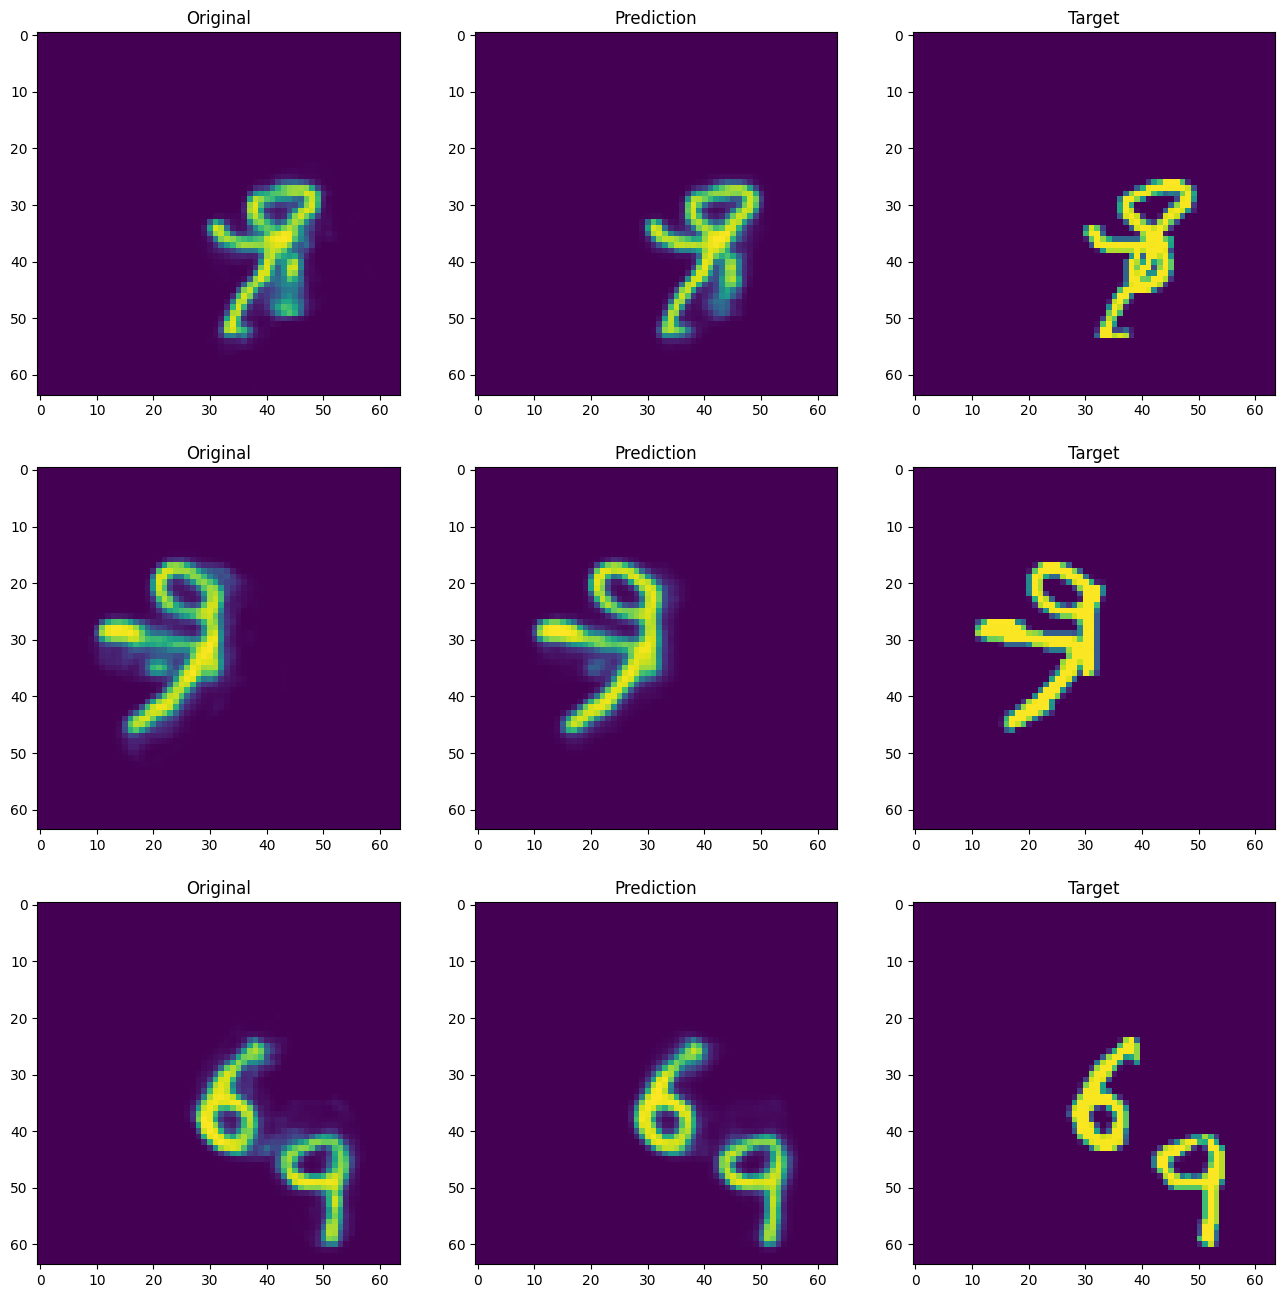

In [94]:
model_post.load_weights('tmp/checkpoint_post_2') # Let's load the best checkpoint and visualize the results
predica = model_post.predict(x_test_post)
fig, ax = plt.subplots(3, 3, figsize=(16,16))
OFFSET = 50
for i in range(3):
    ax[i][0].imshow(x_test_post[i+OFFSET, :, :,:])
    ax[i][0].set_title('Original')
    ax[i][1].imshow(predica[i+OFFSET, :, :,:])
    ax[i][1].set_title('Prediction')
    ax[i][2].imshow(y_test[i+OFFSET, 0, :, :,:])
    ax[i][2].set_title('Target')

The changes are minimal, but undoubtedly improve the results, mainly by erasing small artifacts of the digits, like the little dot under the digit seven in the second row or the small stain between the 6 and the 9 of the third row. Let's now calculate the MSE on the same, whole test set and wrap up this project.

In [95]:
MSE_test_3 = mse(np.reshape(y_test, (5000, 64, 64, 1)), predica).numpy()
print("Final result is an MSE of", MSE_test_3) # Final score for this model!

Final result is an MSE of 0.009298838


# FINAL SCORE: MSE = 0.0092988

1/1 [==============================] - 0s 16ms/step


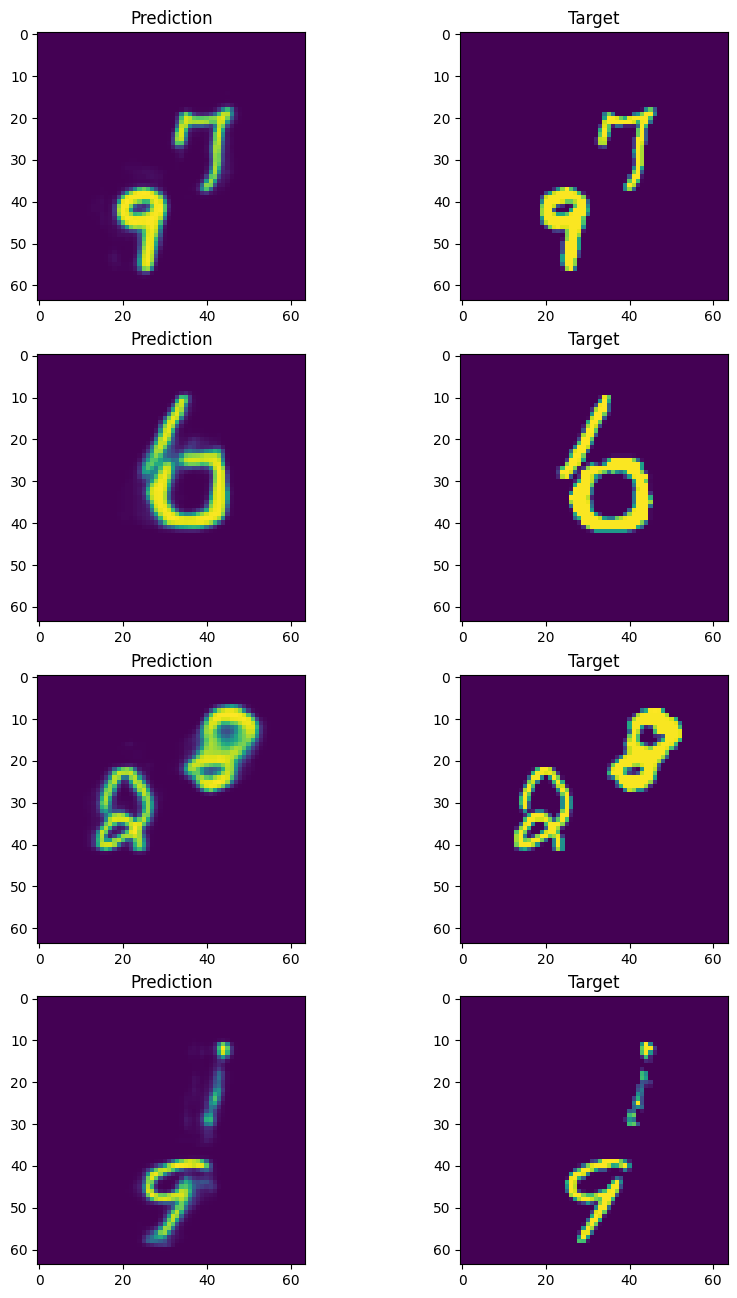

In [91]:
def final_predict(X):   # Function defined to do a whole prediction step in one single call
    temp_pred = custom_predict(model_2, X)
    shape = temp_pred.shape
    temp_pred = np.reshape(temp_pred, (shape[0], shape[2], shape[3], shape[4]))
    return model_post.predict(temp_pred)

final_test = final_predict(x_test[0:4])
fig, ax = plt.subplots(4, 2, figsize=(10,16))
for i in range(4):
    ax[i][0].imshow(final_test[i, :, :,:])
    ax[i][0].set_title('Prediction')
    ax[i][1].imshow(y_test[i, 0, :, :,:])
    ax[i][1].set_title('Target')